In [2]:
import firebase_admin
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from firebase_admin import credentials, firestore
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random

# Firebase Initialization
cred = credentials.Certificate("../adminkey.json")
firebase_admin.initialize_app(cred)
db = firestore.client()

# Constants
INCLUDE_ONLY = ['10000', '10002', '10004', '10007', '10008', '10009']
ACTIVITIES = ['walk', 'stairs']
SAMPLING_RATE = 100
OVERLAP = 0.5
CHUNK_SIZE = 1
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001
#DIFF_THRESHOLD = 35 Not needed anymore, replaced with TES (Treatment Effect Score)

#Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
def fetch_data_by_treatment(treatment_filter):
    data_raw, docs, patients_seen = [], [], set()
    data_ref = db.collection("data").document(treatment_filter)

    for patient_id in INCLUDE_ONLY:
        subject_ref = data_ref.collection(patient_id)
        for activity in ACTIVITIES:
            activity_ref = subject_ref.document(activity)
            phone_location_col = activity_ref.collections()
            for phone_location in phone_location_col:
                for recording in phone_location.stream():
                    key = (patient_id, activity)
                    if key in patients_seen:
                        continue
                    patients_seen.add(key)

                    record = recording.to_dict()
                    if 'acceleration' not in record:
                        continue
                    df = pd.DataFrame(record['acceleration'])
                    timestamps = df['timestamp']
                    min_time = timestamps.min()
                    max_time = timestamps.max()
                    df = df[(timestamps >= min_time + 2500) & (timestamps <= max_time - 2500)]
                    if df.empty:
                        continue
                    combined = pd.DataFrame({
                        'ax': df['accelerometer'].apply(lambda x: x['x']),
                        'ay': df['accelerometer'].apply(lambda x: x['y']),
                        'az': df['accelerometer'].apply(lambda x: x['z']),
                        'gx': df['gyroscope'].apply(lambda x: x['x']),
                        'gy': df['gyroscope'].apply(lambda x: x['y']),
                        'gz': df['gyroscope'].apply(lambda x: x['z']),
                    })
                    data_raw.append(combined)
                    docs.append({'activity': activity, 'patient': patient_id})
    return data_raw, docs

def chunk_data_raw(data_raw, docs, chunk_size_sec, sampling_rate, overlap=OVERLAP):
    data, labels, subjects = [], [], []
    chunk_samples = int(chunk_size_sec * sampling_rate)
    step = int(chunk_samples * (1 - overlap))
    for i, df in enumerate(data_raw):
        for start in range(0, len(df) - chunk_samples + 1, step):
            chunk = df.iloc[start:start + chunk_samples]
            if len(chunk) == chunk_samples:
                data.append(chunk.values)
                labels.append(ACTIVITIES.index(docs[i]['activity']))
                subjects.append(docs[i]['patient'])
    return np.array(data), np.array(labels), np.array(subjects)

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size, dropout=0.1, maxlen=5000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(maxlen, emb_size)
        position = torch.arange(0, maxlen, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, emb_size, 2).float() * (-math.log(10000.0) / emb_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

class TransformerClassifier(nn.Module):
    def __init__(self, input_dim=6, emb_size=32, nhead=4, nhid=64, nlayers=2, nclasses=len(ACTIVITIES), dropout=0.3):
        super().__init__()
        self.embedding = nn.Sequential(
            nn.Linear(input_dim, emb_size),
            nn.LayerNorm(emb_size)
        )
        self.pos_encoder = PositionalEncoding(emb_size, dropout)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=emb_size,
            nhead=nhead,
            dim_feedforward=nhid,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=nlayers)
        self.dropout_fc = nn.Dropout(0.3)
        self.classifier = nn.Sequential(
            nn.Linear(emb_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, nclasses)
        )
        self.emb_size = emb_size

    def forward(self, x):
        x = self.embedding(x) * math.sqrt(self.emb_size)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = self.dropout_fc(x)
        x = self.classifier(x)
        return x

In [5]:
def train_and_evaluate_pre_post(noise_std=0.01):
    # --- Fetch data ---
    before_raw, before_docs = fetch_data_by_treatment('BeforeTreatment')
    X_train_full, y_train_full, subjects_train_full = chunk_data_raw(before_raw, before_docs, CHUNK_SIZE, SAMPLING_RATE, OVERLAP)
    X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(
        X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
    )

    after_raw, after_docs = fetch_data_by_treatment('AfterTreatment')
    X_test_np, y_test_np, subjects_test = chunk_data_raw(after_raw, after_docs, CHUNK_SIZE, SAMPLING_RATE, OVERLAP)

    # --- Normalize ---
    scaler = StandardScaler()
    X_train_np = scaler.fit_transform(X_train_np.reshape(-1, 6)).reshape(X_train_np.shape)
    X_val_np   = scaler.transform(X_val_np.reshape(-1, 6)).reshape(X_val_np.shape)
    X_test_np  = scaler.transform(X_test_np.reshape(-1, 6)).reshape(X_test_np.shape)

    # Gaussian Noise for training data
    #X_train_np += np.random.normal(0.0, noise_std, X_train_np.shape)

    # --- Convert to tensors and loaders ---
    X_train = torch.tensor(X_train_np, dtype=torch.float32)
    y_train = torch.tensor(y_train_np, dtype=torch.long)
    X_val   = torch.tensor(X_val_np, dtype=torch.float32)
    y_val   = torch.tensor(y_val_np, dtype=torch.long)
    X_test  = torch.tensor(X_test_np, dtype=torch.float32)
    y_test  = torch.tensor(y_test_np, dtype=torch.long)

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(TensorDataset(X_val, y_val), batch_size=BATCH_SIZE)
    test_loader  = DataLoader(TensorDataset(X_test, y_test), batch_size=BATCH_SIZE)

    # --- Model setup ---
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = TransformerClassifier().to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

    warmup_epochs = 10
    total_epochs = EPOCHS
    train_acc_history, val_acc_history = [], []

    # --- Training loop ---
    for epoch in range(total_epochs):
        # Adjust learning rate
        if epoch < warmup_epochs:
            lr_scale = 0.1 + 0.9 * (epoch / warmup_epochs)
        else:
            lr_scale = 0.5 * (1 + math.cos(math.pi * (epoch - warmup_epochs) / (total_epochs - warmup_epochs)))
        for pg in optimizer.param_groups:
            pg['lr'] = LEARNING_RATE * lr_scale

        # --- Training step ---
        model.train()
        total_correct, total = 0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_correct += (preds.argmax(dim=1) == yb).sum().item()
            total += yb.size(0)
        train_acc = total_correct / total * 100
        train_acc_history.append(train_acc)

        # --- Validation step ---
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                val_correct += (preds.argmax(dim=1) == yb).sum().item()
                val_total += yb.size(0)
        val_acc = val_correct / val_total * 100
        val_acc_history.append(val_acc)

        print(f"Epoch {epoch+1}/{total_epochs} | LR: {optimizer.param_groups[0]['lr']:.6f} | "
              f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    # --- Plot training history ---
    plt.figure(figsize=(7,5))
    plt.plot(range(1, total_epochs+1), train_acc_history, label='Train Accuracy', marker='o')
    plt.plot(range(1, total_epochs+1), val_acc_history, label='Validation Accuracy', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy per Epoch')
    plt.ylim(0, 105)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.show()

    # --- Test evaluation ---
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            all_preds.extend(preds.argmax(dim=1).cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

    test_acc = (np.array(all_preds) == np.array(all_labels)).mean() * 100
    test_bal_acc = balanced_accuracy_score(all_labels, all_preds) * 100
    test_f1_macro = f1_score(all_labels, all_preds, average='macro') * 100
    test_f1_micro = f1_score(all_labels, all_preds, average='micro') * 100
    test_precision_macro = precision_score(all_labels, all_preds, average='macro', zero_division=0) * 100
    test_recall_macro = recall_score(all_labels, all_preds, average='macro', zero_division=0) * 100
    test_cohen_kappa = cohen_kappa_score(all_labels, all_preds)

    print(f"\nTest Accuracy: {test_acc:.2f}%")
    print(f"Balanced Accuracy: {test_bal_acc:.2f}%")
    print(f"F1 Score: Macro={test_f1_macro:.2f}% | Micro={test_f1_micro:.2f}%")
    print(f"Precision (Macro): {test_precision_macro:.2f}% | Recall (Macro): {test_recall_macro:.2f}%")
    print(f"Cohen's Kappa: {test_cohen_kappa:.3f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, labels=range(len(ACTIVITIES)), target_names=ACTIVITIES, zero_division=0))

    # --- Confusion matrix ---
    cm = confusion_matrix(all_labels, all_preds, labels=range(len(ACTIVITIES)))
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=ACTIVITIES, yticklabels=ACTIVITIES)
    plt.title('Confusion Matrix: After Treatment')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # --- Per-patient evaluation & Treatment Effect Score (TES) ---
    TES = {}
    for patient_id in np.unique(subjects_test):
        idx = subjects_test == patient_id
        patient_labels = np.array(all_labels)[idx]
        patient_preds  = np.array(all_preds)[idx]
        patient_acc = accuracy_score(patient_labels, patient_preds) * 100
        TES[patient_id] = train_acc_history[-1] - patient_acc  # TES

        print(f"\nPatient {patient_id} evaluation:")
        print(classification_report(patient_labels, patient_preds, labels=range(len(ACTIVITIES)), target_names=ACTIVITIES, zero_division=0))
        print(f"Treatment Effect Score (TES) = {TES[patient_id]:.2f}")

    # --- Placeholder: NRS-based improvement info (replace with real clinical data) ---
    patient_improvement = {
        '10000': True,  
        '10002': True,
        '10004': False,
        '10007': True,
        '10008': True,
        '10009': True
    }

    # --- TES threshold using only improved patients ---
    improved_TES_values = [
        score for patient, score in TES.items()
        if patient_improvement.get(patient, False)
    ]

    if len(improved_TES_values) > 0:
        TES_THRESHOLD = np.mean(improved_TES_values)
    else:
        TES_THRESHOLD = None 

    # --- TES visualization ---
    plt.figure(figsize=(8,5))
    patients = list(TES.keys())
    scores = list(TES.values())

    if TES_THRESHOLD is not None:
        colors = ['orange' if score >= TES_THRESHOLD else 'steelblue' for score in scores]
    else:
        colors = ['steelblue'] * len(scores)

    sns.barplot(x=patients, y=scores, palette=colors)
    plt.xlabel("Patient ID")
    plt.ylabel("Treatment Effect Score (TES)")
    if TES_THRESHOLD is not None:
        plt.title(f"Per-Patient TES (Threshold = {TES_THRESHOLD:.1f})")
    else:
        plt.title("Per-Patient TES (No responders, no threshold)")

    plt.grid(True, linestyle='--', alpha=0.5)

    # Annotate bars
    for i, score in enumerate(scores):
        plt.text(i, score + 1, f"{score:.1f}", ha='center')

    plt.show()

    return {
        'train_acc_history': train_acc_history,
        'val_acc_history': val_acc_history,
        'test_acc': test_acc,
        'test_bal_acc': test_bal_acc,
        'test_f1_macro': test_f1_macro,
        'test_f1_micro': test_f1_micro,
        'test_precision_macro': test_precision_macro,
        'test_recall_macro': test_recall_macro,
        'test_cohen_kappa': test_cohen_kappa,
        'all_preds': all_preds,
        'all_labels': all_labels,
        'TES': TES,
        'TES_THRESHOLD': TES_THRESHOLD
    }

Epoch 1/50 | LR: 0.000100 | Train Acc: 45.32% | Val Acc: 49.15%
Epoch 2/50 | LR: 0.000190 | Train Acc: 54.26% | Val Acc: 61.86%
Epoch 3/50 | LR: 0.000280 | Train Acc: 54.47% | Val Acc: 61.02%
Epoch 4/50 | LR: 0.000370 | Train Acc: 59.57% | Val Acc: 64.41%
Epoch 5/50 | LR: 0.000460 | Train Acc: 63.19% | Val Acc: 65.25%
Epoch 6/50 | LR: 0.000550 | Train Acc: 66.38% | Val Acc: 68.64%
Epoch 7/50 | LR: 0.000640 | Train Acc: 68.30% | Val Acc: 74.58%
Epoch 8/50 | LR: 0.000730 | Train Acc: 72.34% | Val Acc: 77.97%
Epoch 9/50 | LR: 0.000820 | Train Acc: 77.23% | Val Acc: 83.90%
Epoch 10/50 | LR: 0.000910 | Train Acc: 80.64% | Val Acc: 83.05%
Epoch 11/50 | LR: 0.001000 | Train Acc: 85.53% | Val Acc: 83.90%
Epoch 12/50 | LR: 0.000998 | Train Acc: 87.23% | Val Acc: 82.20%
Epoch 13/50 | LR: 0.000994 | Train Acc: 88.72% | Val Acc: 88.98%
Epoch 14/50 | LR: 0.000986 | Train Acc: 90.00% | Val Acc: 83.05%
Epoch 15/50 | LR: 0.000976 | Train Acc: 91.70% | Val Acc: 92.37%
Epoch 16/50 | LR: 0.000962 | Train

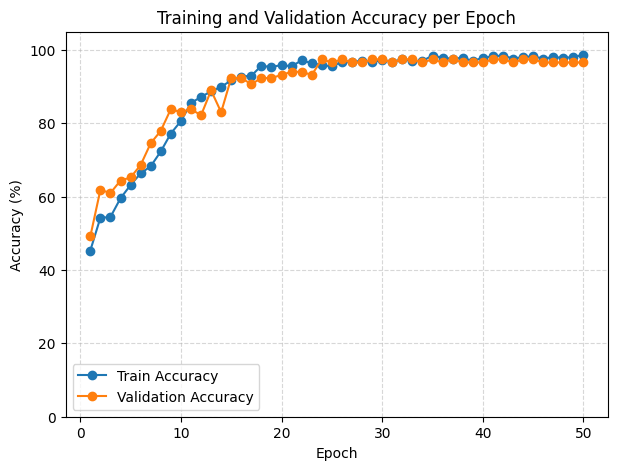


Test Accuracy: 61.73%
Balanced Accuracy: 61.73%
F1 Score: Macro=61.32% | Micro=61.73%
Precision (Macro): 62.26% | Recall (Macro): 61.73%
Cohen's Kappa: 0.235

Classification Report:
              precision    recall  f1-score   support

        walk       0.65      0.51      0.57       294
      stairs       0.60      0.72      0.65       294

    accuracy                           0.62       588
   macro avg       0.62      0.62      0.61       588
weighted avg       0.62      0.62      0.61       588



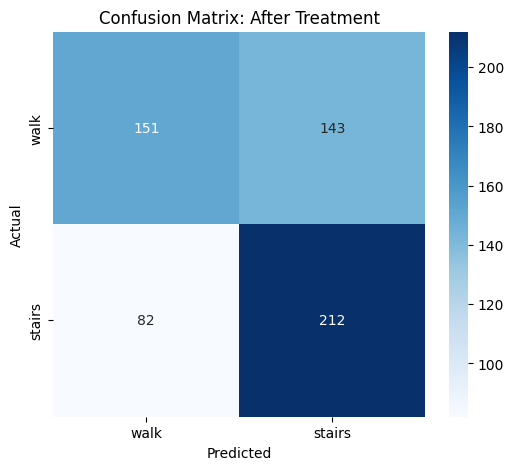


Patient 10000 evaluation:
              precision    recall  f1-score   support

        walk       0.59      0.90      0.71        49
      stairs       0.78      0.37      0.50        49

    accuracy                           0.63        98
   macro avg       0.68      0.63      0.60        98
weighted avg       0.68      0.63      0.60        98

Treatment Effect Score (TES) = 35.46

Patient 10002 evaluation:
              precision    recall  f1-score   support

        walk       0.00      0.00      0.00        49
      stairs       0.49      0.96      0.65        49

    accuracy                           0.48        98
   macro avg       0.24      0.48      0.32        98
weighted avg       0.24      0.48      0.32        98

Treatment Effect Score (TES) = 50.76

Patient 10004 evaluation:
              precision    recall  f1-score   support

        walk       0.81      0.78      0.79        49
      stairs       0.78      0.82      0.80        49

    accuracy               

C:\Users\wenzh\AppData\Local\Temp\ipykernel_35084\28655811.py:175: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=patients, y=scores, palette=colors)


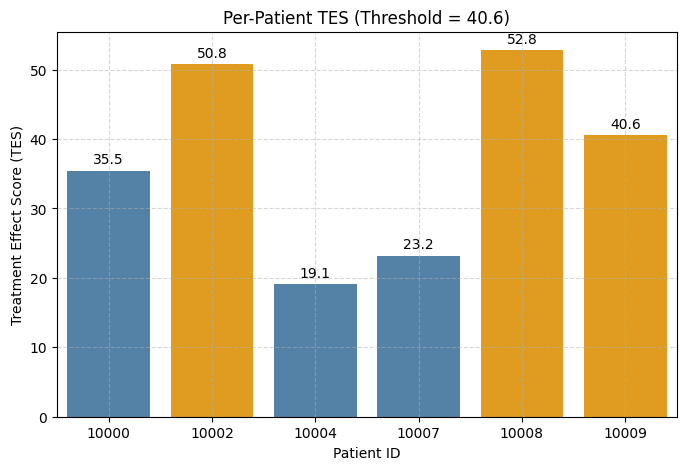

In [6]:
if __name__ == "__main__":
    train_and_evaluate_pre_post()